In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 100)

import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# cow_id vs lactation_number?
# remark, r, t, b???
columns = ['cow_id', 'lactation_number', 'event', 'days_in_milk', 'date', 'remark', 'r', 't', 'b']

breedings = pd.read_csv(
    'data/breedings.csv',
    header=0,
    names=columns,
    converters={'event': lambda x: x.strip(), 
                'date': lambda x: pd.to_datetime(x, errors='coerce'), 
                'remark': lambda x: x.strip(), 
                'r': lambda x: x.strip(), 
                'b': lambda x: x.strip()})

breedings = breedings.sort_values(by=['date'])

In [3]:
# data_entry = (cow_id, lactation_number, calving_date, event)

calves_dict = dict()
for index, row in breedings.iterrows():
    calving_date = row.date - pd.Timedelta(days=row.days_in_milk)
    entry = (row.cow_id, row.lactation_number, calving_date, row.event)
    info = {'days_in_milk': row.days_in_milk, 'date': row.date, 'remark': row.remark, 'r': row.r, 't': row.t, 'b': row.b}
    if entry in calves_dict:
        # this cow has already been born, update entry
        log = calves_dict[entry]
        # check for errors
        assert log[-1]['days_in_milk'] <= info['days_in_milk'] and log[-1]['date'] <= info['date']
        log.append(info)
    else:
        # calf was born 
        calves_dict[entry] = [info]

calves = pd.DataFrame(data=calves_dict.keys(), columns=['cow_id', 'lactation_number', 'calving_date', 'event'])
calves = calves.sort_values(by=['cow_id'])
calves.head()

,cow_id,lactation_number,calving_date,event
799,1,3,2018-06-04,BRED
2243,1,4,2019-06-09,BRED
787,2,2,2018-06-04,BRED
934,4,2,2018-07-08,BRED
2168,6,2,2019-01-01,BRED


In [4]:
data = pd.DataFrame()

i = 0
for file_name in os.listdir('data/'):
    if i > 10:
        break
    i += 1
    if file_name != 'breedings.csv' and file_name.split('.')[1] == 'csv':
        data = data.append(pd.read_csv('data/' + file_name))

In [5]:
# ??: 'act_heat_index', 'act_heat_index_smart', 'heat_index', 'temp_dec_index', 'temp_height_index', 'temp_inc_index'
data.columns = ['act_heat_index', 'act_heat_index_smart', 'activity', 'heat_index', 'activity_1day_avg', '60percentile_of_5day_temp', 'temp', 'temp_dec_index', 'temp_height_index', 'temp_inc_index', 'temp_without_drink_cycles', 'time', 'cow_id']

data.time = pd.to_datetime(data.time, errors='coerce')

temp_dec_index = data[data.activity_1day_avg.isnull()]
data = data[~data.activity_1day_avg.isnull()]

data = data.drop(['heat_index', 'temp', 'temp_dec_index', 'act_heat_index'], axis=1)
temp_dec_index = temp_dec_index[['temp_dec_index', 'time', 'cow_id']]

# smoothing
data.temp_without_drink_cycles = data.temp_without_drink_cycles.rolling(12*6, min_periods=1, center=True).mean()
data.activity = data.activity.rolling(24*6, min_periods=1, center=True).mean()
data.activity_1day_avg = data.activity_1day_avg.rolling(24*6, min_periods=1, center=True).mean()
data.temp_height_index = data.temp_height_index.rolling(12*6, min_periods=1, center=True).mean()
data.act_heat_index_smart = data.act_heat_index_smart.rolling(24*6, min_periods=1, center=True).mean()

# scaling to a max height of 10
temp_dec_index.temp_dec_index = temp_dec_index.temp_dec_index / (temp_dec_index.temp_dec_index.max() - temp_dec_index.temp_dec_index.min()) * 10
data.temp_without_drink_cycles = data.temp_without_drink_cycles / (data.temp_without_drink_cycles.max() - data.temp_without_drink_cycles.min()) * 10
data['60percentile_of_5day_temp'] = data['60percentile_of_5day_temp'] / (data['60percentile_of_5day_temp'].max() - data['60percentile_of_5day_temp'].min()) * 10
data.temp_height_index = data.temp_height_index / (data.temp_height_index.max() - data.temp_height_index.min()) * 10
data.temp_inc_index = data.temp_inc_index / (data.temp_inc_index.max() - data.temp_inc_index.min()) * 10
data.activity_1day_avg = data.activity_1day_avg / (data.activity_1day_avg.max() - data.activity_1day_avg.min()) * 10
data.activity = data.activity / (data.activity.max() - data.activity.min()) * 10
data.act_heat_index_smart = data.act_heat_index_smart / (data.act_heat_index_smart.max() - data.act_heat_index_smart.min()) * 10

data.head()

,act_heat_index_smart,activity,activity_1day_avg,60percentile_of_5day_temp,temp_height_index,temp_inc_index,temp_without_drink_cycles,time,cow_id
0,NaN,2.813913,2.835251,NaN,NaN,NaN,12.245852,2018-07-18 16:56:00,9915
1,NaN,2.792945,2.823063,NaN,NaN,NaN,12.248146,2018-07-18 17:06:00,9915
2,NaN,2.760504,2.809411,NaN,NaN,NaN,12.251369,2018-07-18 17:16:00,9915
3,NaN,2.758788,2.795297,NaN,NaN,NaN,12.254670,2018-07-18 17:26:00,9915
4,NaN,2.739803,2.780000,NaN,NaN,NaN,12.258377,2018-07-18 17:36:00,9915


In [6]:
temp_dec_index.head()

,temp_dec_index,time,cow_id
547,0.000000,2018-07-22 12:00:00,9915
554,0.084918,2018-07-22 13:00:00,9915
561,0.129076,2018-07-22 14:00:00,9915
568,0.261549,2018-07-22 15:00:00,9915
575,0.414402,2018-07-22 16:00:00,9915


In [8]:
cows = dict()
for cow in set(data.cow_id):
    cows[cow] = {'df': data[data.cow_id == cow].reset_index(), 
                 'temp_dec_index': temp_dec_index[temp_dec_index.cow_id == cow].reset_index()}

In [16]:
HEAT_MIN = 8*6
HEAT_MAX = 30*6

CYCLE_MIN = 21*24*6
CYCLE_MAX = 21*24*6

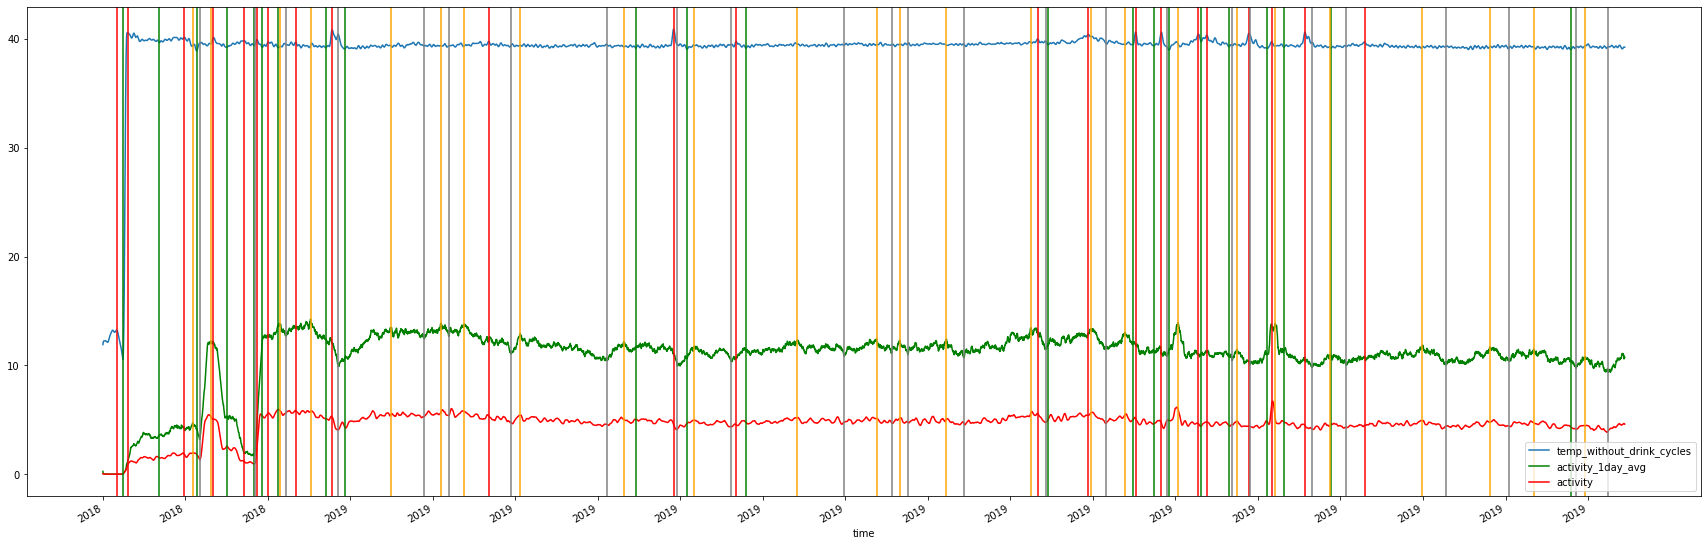

In [29]:
def plot_cow(cow_id):
    ax = plt.gca()
    
    df = cows[cow_id]

    dates = (min(df.time), max(df.time))
    df.plot(kind='line', x='time', y='temp_without_drink_cycles', ax=ax, figsize=(30, 10), xticks=np.arange(dates[0], dates[1], pd.Timedelta(days=21)))
    df.plot(kind='line', x='time', y='activity_1day_avg', color='green', ax=ax)
    df.plot(kind='line', x='time', y='activity', color='red', ax=ax)
    
    peaks1, properties1 = find_peaks(df.temp_without_drink_cycles, prominence=0.5)
    peaks2, properties2 = find_peaks(-df.temp_without_drink_cycles, prominence=0.5)
    peaks3, properties3 = find_peaks(df.activity_1day_avg, prominence=1)
    peaks4, properties4 = find_peaks(-df.activity_1day_avg, prominence=1)
    
#     print(properties1)
    peak_indices = np.concatenate([df.time.iloc[peaks1], df.time.iloc[peaks2], df.time.iloc[peaks3], df.time.iloc[peaks4]])
    
    for x in df.time.iloc[peaks1]:
        ax.axvline(x, color='red')
    for x in df.time.iloc[peaks2]:
        ax.axvline(x, color='green')
    for x in df.time.iloc[peaks3]:
        ax.axvline(x, color='orange')
    for x in df.time.iloc[peaks4]:
        ax.axvline(x, color='grey')
    
    for date in calves[calves.cow_id == cow_id].calving_date:
        pregnancy = (date - pd.Timedelta(days=283), date)
        if pregnancy[1] > dates[0] and pregnancy[0] < dates[1]:
            ax.axvspan(pregnancy[0], pregnancy[1], color='purple', alpha=0.25)

    plt.show()

plot_cow(list(cows.keys())[0])

# for cow in cows.keys():
#     plot_cow(cow)

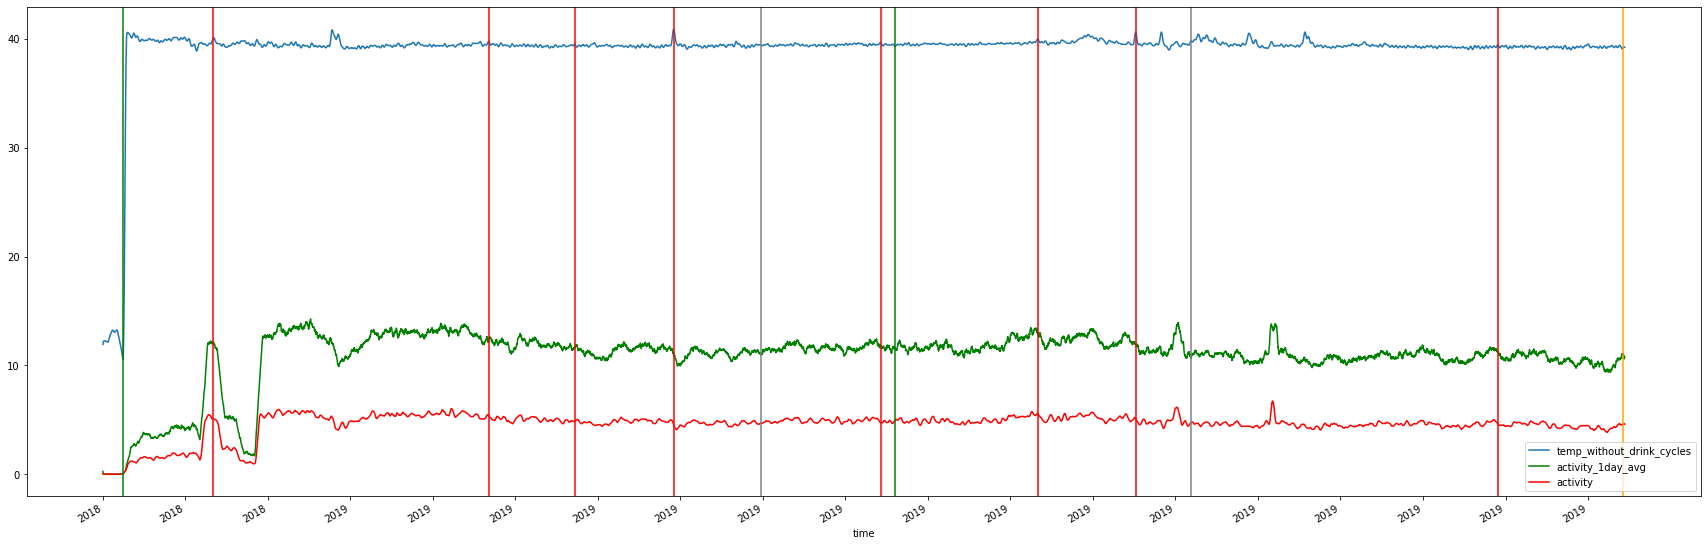

In [30]:
from scipy.signal import find_peaks

def plot_cow2(cow_id):
    ax = plt.gca()
    
    df = cows[cow_id]

    dates = (min(df.time), max(df.time))
    df.plot(kind='line', x='time', y='temp_without_drink_cycles', ax=ax, figsize=(30, 10), xticks=np.arange(dates[0], dates[1], pd.Timedelta(days=21)))
    df.plot(kind='line', x='time', y='activity_1day_avg', color='green', ax=ax)
    df.plot(kind='line', x='time', y='activity', color='red', ax=ax)
    
    peaks1, properties1 = find_peaks(df.temp_without_drink_cycles, distance=CYCLE_MIN, width=(HEAT_MIN, HEAT_MAX))
    peaks2, properties2 = find_peaks(-df.temp_without_drink_cycles, distance=CYCLE_MIN, width=(HEAT_MIN, HEAT_MAX))
    peaks3, properties3 = find_peaks(df.activity_1day_avg, distance=CYCLE_MIN, width=(HEAT_MIN, HEAT_MAX))
    peaks4, properties4 = find_peaks(-df.activity_1day_avg, distance=CYCLE_MIN, width=(HEAT_MIN, HEAT_MAX))
    
    peak_indices = np.concatenate([df.time.iloc[peaks1], df.time.iloc[peaks2], df.time.iloc[peaks3], df.time.iloc[peaks4]])
    
    for x in df.time.iloc[peaks1]:
        ax.axvline(x, color='red')
    for x in df.time.iloc[peaks2]:
        ax.axvline(x, color='green')
    for x in df.time.iloc[peaks3]:
        ax.axvline(x, color='orange')
    for x in df.time.iloc[peaks4]:
        ax.axvline(x, color='grey')
    
    for date in calves[calves.cow_id == cow_id].calving_date:
        pregnancy = (date - pd.Timedelta(days=283), date)
        if pregnancy[1] > dates[0] and pregnancy[0] < dates[1]:
            ax.axvspan(pregnancy[0], pregnancy[1], color='purple', alpha=0.25)

    plt.show()

plot_cow2(list(cows.keys())[0])

# for cow in cows.keys():
#     plot_cow2(cow)

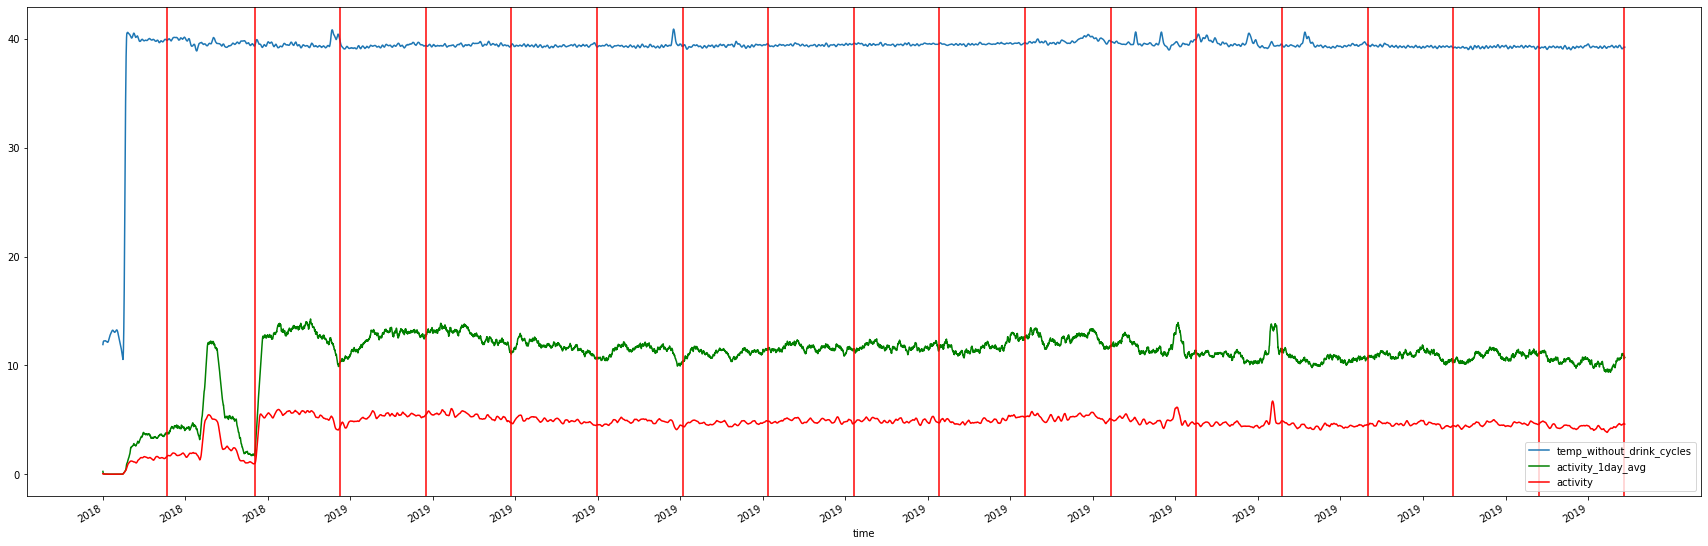

In [35]:
def get_max(x1, x2, peaks1, properties1, peaks2, properties2, peaks3, properties3, peaks4, properties4):
    # (index, value)
    res1 = [(peaks1[i], properties1['prominences'][i]) for i in range(len(peaks1)) if peaks1[i] > x1 and peaks1[i] < x2]
    res2 = [(peaks2[i], properties2['prominences'][i]) for i in range(len(peaks2)) if peaks2[i] > x1 and peaks2[i] < x2]
    res3 = [(peaks3[i], properties3['prominences'][i]) for i in range(len(peaks3)) if peaks3[i] > x1 and peaks3[i] < x2]
    res4 = [(peaks4[i], properties4['prominences'][i]) for i in range(len(peaks4)) if peaks4[i] > x1 and peaks4[i] < x2]
    res = res1 + res2 + res3 + res4
    
    if res:
        return max(res, key=lambda x: x[1])
    else:
        return ((x1 + x2) / 2, 0)


def plot_cow(cow_id):
    ax = plt.gca()
    
    df = cows[cow_id]

    dates = (min(df.time), max(df.time))
    df.plot(kind='line', x='time', y='temp_without_drink_cycles', ax=ax, figsize=(30, 10), xticks=np.arange(dates[0], dates[1], pd.Timedelta(days=21)))
    df.plot(kind='line', x='time', y='activity_1day_avg', color='green', ax=ax)
    df.plot(kind='line', x='time', y='activity', color='red', ax=ax)
    
    peaks1, properties1 = find_peaks(df.temp_without_drink_cycles, prominence=0.5)
    peaks2, properties2 = find_peaks(-df.temp_without_drink_cycles, prominence=0.5)
    peaks3, properties3 = find_peaks(df.activity_1day_avg, prominence=1)
    peaks4, properties4 = find_peaks(-df.activity_1day_avg, prominence=1)
    
    peak_indices = np.concatenate([df.time.iloc[peaks1], df.time.iloc[peaks2], df.time.iloc[peaks3], df.time.iloc[peaks4]])
    
    results = dict()
    for i in range(CYCLE_MIN):
        results[i] = {'value': 0, 'points': []}
        j = i
        while j < len(df):
            m = get_max(j + HEAT_MIN, j + HEAT_MAX, peaks1, properties1, peaks2, properties2, peaks3, properties3, peaks4, properties4)
            results[i]['value'] += m[1]
            results[i]['points'].append(m[0])
            j = m[0] + CYCLE_MIN
            
    result = max(results.items(), key=lambda x: x[1]['value'])
    for x in df.time.iloc[result[1]['points']]:
        ax.axvline(x, color='red')
    
    
#     for x in df.time.iloc[peaks1]:
#         ax.axvline(x, color='red')
#     for x in df.time.iloc[peaks2]:
#         ax.axvline(x, color='green')
#     for x in df.time.iloc[peaks3]:
#         ax.axvline(x, color='orange')
#     for x in df.time.iloc[peaks4]:
#         ax.axvline(x, color='grey')
    
    for date in calves[calves.cow_id == cow_id].calving_date:
        pregnancy = (date - pd.Timedelta(days=283), date)
        if pregnancy[1] > dates[0] and pregnancy[0] < dates[1]:
            ax.axvspan(pregnancy[0], pregnancy[1], color='purple', alpha=0.25)

    plt.show()

plot_cow(list(cows.keys())[0])

# for cow in cows.keys():
#     plot_cow(cow)